In [1]:
# Data preparation for Ph.D thesis
# copy from INDICATORS_DATASET_RAW_DATA_FOR_TS-GENERATOR-PARSING.ipynb
# @author: Andres L. Suarez-Cetrulo
%config IPCompleter.greedy=True
%load_ext jupyternotify
%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
# Imports
import pandas as pd
import numpy as np
import datetime
from pathlib import Path
import os
import matplotlib.pyplot as plt

# Using TALib abstract API to create a dictionary of technical indicators to iterate later.
from talib import abstract

In [2]:
!python -m pip install notebook-as-pdf

  Using cached https://files.pythonhosted.org/packages/56/01/1f61610f1eb7f9a8e8fdc607a89dd2fae778e6e43290d7e153ebe724adb5/websockets-8.1-cp37-cp37m-win_amd64.whl
  Stored in directory: C:\Users\suare\AppData\Local\pip\Cache\wheels\53\84\19\35bc977c8bf5f0c23a8a011aa958acd4da4bbd7a229315c1b7
Successfully built PyPDF2


ERROR: Could not install packages due to an EnvironmentError: [WinError 2] The system cannot find the file specified: 'C:\\Users\\suare\\Anaconda3\\Lib\\site-packages\\PyPDF2-1.26.0.dist-info\\top_level.txt'



In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#### The first step is to run 1_rawdata_processing.py in the project QuantQuoteDataPreprocessing. 
- Run this for the desired ETF symbols, frequency and period (check in config.yaml).
- Move output files to the input directory of the next cell below ('path' val)

#### Then, parse the series (removing out of market hours)

In [4]:
# path = os.sep.join(['C:','Users','suare','PycharmProjects','RegimeSwitchingSeriesGenerator','data','efts','30min-level',
#                     'IBEX','IBEX_[2017-01-01_to_2018-01-01]'])
sources = ['S&P500']
#date_ranges = ['[2014-12-01_to_2015-01-01]' ,'[2015-01-01_to_2016-01-01]', '[2016-01-01_to_2017-01-01]', 
#               '[2017-01-01_to_2018-01-01]', '[2018-01-01_to_2019-01-01]']
files = list()
levels = ['1min-level'] # ,'5min-level','10min-level','15min-level','30min-level']
for source in sources:
    for level in levels:
        print(f'Source {source} at level {level}')
        for file in ['spy_alphavantage_2017']: # ['SPY_[2017-09-22_to_2017-12-09]']:  #['spy_alphavantage_2017', 'spy_alphavantage_2018', 'spy_alphavantage_2019_2020']:
            path = os.sep.join(['C:','Users','suare','OneDrive', 'Escritorio', file])  # new - moving data across
            df = pd.read_csv(path+'.csv', sep=',')
            print(df)
            df.rename(columns={'date':'datetime'}, inplace=True)
            df.index = pd.to_datetime(df.datetime)
            df.drop(columns=['datetime'], inplace=True)
            df.sort_index(inplace=True)
            ohlc_dict = {'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume': 'sum'}
            df = df.resample(level.split('-')[0]).agg(ohlc_dict)
    #         df = df.between_time('09:30','15:59')
            df.dropna(inplace=True)

            print(len(df))
    #         df = df.between_time('09:30','16:00')
            # if filling missing values
    #         df['volume'] = df['volume'].fillna(0)
    #         df['close'] = df['close'].ffill()
    #         df['open'] = df['open'].fillna(df['close'])
    #         df['low'] = df['low'].fillna(df['close'])
    #         df['high'] = df['high'].fillna(df['close'])
    #         df['datetime'] = df.index
            path = os.sep.join(['C:','Users','suare','PycharmProjects','RegimeSwitchingSeriesGenerator','data','efts',level,
                        source,'_'.join([file, 'no_missing_data'])])
            dir_path = os.sep.join(path.split(os.sep)[:-1])
            if not os.path.exists(dir_path):
                os.makedirs(dir_path)
            df.to_csv(path+'_market_hours_no_missing_data.csv', sep=';')
    #         os.remove(path+'_market_hours.csv')
            files.append(path+'_market_hours_no_missing_data.csv')
# files

Source S&P500 at level 1min-level
                      date    close     high      low     open     volume
0      2017-09-11 09:30:00  248.040  248.050  248.035  248.040   195320.0
1      2017-09-11 09:31:00  248.100  248.170  248.030  248.040   191201.0
2      2017-09-11 09:32:00  248.160  248.180  248.090  248.110    76710.0
3      2017-09-11 09:33:00  248.220  248.240  248.150  248.160   151905.0
4      2017-09-11 09:34:00  248.310  248.350  248.230  248.240   168466.0
5      2017-09-11 09:35:00  248.340  248.340  248.280  248.300    85173.0
6      2017-09-11 09:36:00  248.300  248.390  248.300  248.350   104646.0
7      2017-09-11 09:37:00  248.300  248.340  248.280  248.295    60156.0
8      2017-09-11 09:38:00  248.300  248.350  248.290  248.310    55077.0
9      2017-09-11 09:39:00  248.370  248.390  248.280  248.310    55475.0
10     2017-09-11 09:40:00  248.495  248.495  248.340  248.370   141129.0
11     2017-09-11 09:41:00  248.480  248.500  248.460  248.495   135665.0
12  

#### Now let's define indicators, paths, and start the transformation process

In [5]:
# Creating a dictionary of technical indicators using TALib abstract API
indicators = ['sma','ema','wma','mom','stoch','macd' ,'rsi' ,'willr',
              'adosc' ,'cci','adx','aroon' ,'bbands','obv' ,'trima',
              'roc' ,'rocr','stochf','medprice','typprice','wclprice',
              'atr','macdfix','mfi' ,'sar' ,'ppo']

def get_indicator(ind: str):
    return abstract.Function(ind)

# Add as many indicators as necessary: see all indicators in https://mrjbq7.github.io/ta-lib/

In [6]:
import subprocess
# Define this to parse the CSVs to ARFF later automatically
def create_arff_file(filename, output=None):
    java_mem = '-Xmx3074m'
    filename = filename.replace('.csv', '')
    if output is None:
        output=filename
    else:
        output = output.replace('.csv', '')
    wekadev_libpath = 'C:\\Users\\suare\\Workspace\\phd_cetrulin\\moa-2017.06-sources\\lib\\weka-dev-3.7.12.jar'
    command = ['java', java_mem, '-classpath', wekadev_libpath,
               'weka.core.converters.CSVLoader', filename + '.csv', '>', output + '.arff']
    f = open(filename + '.arff', "w")
    subprocess.call(command, stdout=f)
    print('If the arff is not generated, run the next in the terminal.')
    print(str(' '.join(command)))

In [7]:
# Paths for symbols (not eft)
DATA_PATH=os.sep.join(['C:','Users','suare','PycharmProjects','RegimeSwitchingSeriesGenerator','data'])
# '/Users/asuarez/Downloads'
SOURCE_PATH=DATA_PATH # +'raw\\alpha_vantage\\S&P500\\symbols\\AAPL\\'  # 'raw/alpha_vantage/'
RESULT_PATH=os.sep.join(['C:','Users','suare','PycharmProjects','RegimeSwitchingSeriesGenerator','output']) # +'analysis\\'+SYMBOL.lower()+'\\'

# List of dates for files to be loaded
# raw_datasets = ['aapl\\APPLE_[2018-08-01_to_2018-09-11]_5min.csv',
#                   'btc\\BITCOIN_[2019-07-01_to_2019-07-15]_5min.csv',
#                   'xrp\\RIPPLE_[2019-07-01_to_2019-08-01]_5min.csv',
#                   'efts\\5min-level\\DOWJONES\\DOWJONES_[2015-08-01_to_2015-08-31]_market_hours.csv']
raw_datasets = ['efts\\'+level+'\\DOWJONES\\DOWJONES_[2015-01-01_to_2016-01-01]_market_hours.csv']
    
filename = raw_datasets[0] # 'timeseries_created_21-10-2019' # 'timeseries_created_1571527428'
FIELD = 'close' # price->'ts' returns->'ret_ts' ts_with_added_noise-> 'ts_n2_post'

file = os.sep.join([SOURCE_PATH, filename])
RESULT_FILEPATH_PROCESSED = os.sep.join([RESULT_PATH, filename.split(os.sep)[-1].replace('.csv','')+'_indicators_best_17052020.csv'])

In [8]:
# Open file
df=pd.read_csv(file, sep=';')
print(df.head())

df['close'] = df[FIELD]
df.close.head()

              datetime      open      high       low    close   volume  gap  \
0  2015-01-02 09:30:00  178.6200  178.7300  178.5601  178.660  84826.0  0.0   
1  2015-01-02 09:31:00  178.6800  178.7154  178.5701  178.690  19078.0  0.0   
2  2015-01-02 09:32:00  178.7099  178.8040  178.6800  178.804  12179.0  0.0   
3  2015-01-02 09:33:00  178.7950  178.8900  178.7700  178.890  16965.0  0.0   
4  2015-01-02 09:34:00  178.8900  178.9100  178.8300  178.870  22910.0  0.0   

    timestamp  
0  1420191000  
1  1420191060  
2  1420191120  
3  1420191180  
4  1420191240  


0    178.660
1    178.690
2    178.804
3    178.890
4    178.870
Name: close, dtype: float64

In [9]:
#Add parameters to transform in TS
timeseries=['close', 'open', 'high', 'low']
#Length of the TS. How many values do we keep per serie. 
# e.g. 1 -> t / 2 -> t,t-1 / 3 -> t,t-1,t-2 / 4 -> t,t-1,t-2,t-3
length = 5

# Add lagged times
for column in timeseries:
    #df[column+'_t']=df[column]
    for i in range(1,length):
        df[column+'_t-'+str(i)]=df[column].shift(i) #it could also be sorted and group by if needed
    #del drops the delected df column
    #del df[column]
df.head()

,datetime,open,high,low,close,volume,gap,timestamp,close_t-1,close_t-2,...,open_t-3,open_t-4,high_t-1,high_t-2,high_t-3,high_t-4,low_t-1,low_t-2,low_t-3,low_t-4
0,2015-01-02 09:30:00,178.6200,178.7300,178.5601,178.660,84826.0,0.0,1420191000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-02 09:31:00,178.6800,178.7154,178.5701,178.690,19078.0,0.0,1420191060,178.660,NaN,...,NaN,NaN,178.7300,NaN,NaN,NaN,178.5601,NaN,NaN,NaN
2,2015-01-02 09:32:00,178.7099,178.8040,178.6800,178.804,12179.0,0.0,1420191120,178.690,178.660,...,NaN,NaN,178.7154,178.7300,NaN,NaN,178.5701,178.5601,NaN,NaN
3,2015-01-02 09:33:00,178.7950,178.8900,178.7700,178.890,16965.0,0.0,1420191180,178.804,178.690,...,178.62,NaN,178.8040,178.7154,178.7300,NaN,178.6800,178.5701,178.5601,NaN
4,2015-01-02 09:34:00,178.8900,178.9100,178.8300,178.870,22910.0,0.0,1420191240,178.890,178.804,...,178.68,178.62,178.8900,178.8040,178.7154,178.73,178.7700,178.6800,178.5701,178.5601


In [11]:
# all the numbers here and below assume a default time period for ta params of 10 mins averages
# change the other numbers (params of 5min and 20min and theremoval of 20 first mins of the day below) if the mins number is changed.
# in that case change as well the time tag '_10' with the corresponding one.
default_timerange=10
# Set extra timeranges for moving averages
extra_timeranges=[default_timerange/2, default_timerange, default_timerange*2, default_timerange*3]

# ###########################################
# Iterate and run list of indicators selected
# All of them produced for 25 prior mins of data 
# ###########################################
for ind in list(indicators):
    if ind not in ['adosc', 'obv', 'mfi']:  # avoiding indicators that need volume
        # For indicators that only return one column (this will need to be modified depending on the selection of indicators)
        if ind in ['ema','sma','trima']:
            for timerange in extra_timeranges:
                df[ind+'_'+str(int(timerange))] = get_indicator(ind)(df, timeperiod=timerange) 
        elif ind not in ['bbands','aroon','stoch','macd','macdfix','stochf']:
            df[ind+'_'+str(int(default_timerange))] = get_indicator(ind)(df, timeperiod=(default_timerange))
        # Otherwise check the list of columns and return all
        else: 
            key_output=get_indicator(ind)(df, timeperiod=(default_timerange)) #, price='close')
            for j in range(0,len(list(key_output.columns))):
                df[ind+'_'+key_output.columns[int(j)]] = key_output[key_output.columns[j]]
df.head()

,datetime,open,high,low,close,volume,gap,timestamp,close_t-1,close_t-2,...,stochf_fastd,medprice_10,typprice_10,wclprice_10,atr_10,macdfix_macd,macdfix_macdsignal,macdfix_macdhist,sar_10,ppo_10
0,2015-01-02 09:30:00,178.6200,178.7300,178.5601,178.660,84826.0,0.0,1420191000,NaN,NaN,...,NaN,178.64505,178.650033,178.652525,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-02 09:31:00,178.6800,178.7154,178.5701,178.690,19078.0,0.0,1420191060,178.660,NaN,...,NaN,178.64275,178.658500,178.666375,NaN,NaN,NaN,NaN,178.560100,NaN
2,2015-01-02 09:32:00,178.7099,178.8040,178.6800,178.804,12179.0,0.0,1420191120,178.690,178.660,...,NaN,178.74200,178.762667,178.773000,NaN,NaN,NaN,NaN,178.563206,NaN
3,2015-01-02 09:33:00,178.7950,178.8900,178.7700,178.890,16965.0,0.0,1420191180,178.804,178.690,...,NaN,178.83000,178.850000,178.860000,NaN,NaN,NaN,NaN,178.570100,NaN
4,2015-01-02 09:34:00,178.8900,178.9100,178.8300,178.870,22910.0,0.0,1420191240,178.890,178.804,...,NaN,178.87000,178.870000,178.870000,NaN,NaN,NaN,NaN,178.589294,NaN


In [144]:
df

,rsi_10,willr_10,macd_macd,cci_10,mom_10,stoch_slowk,stoch_slowd,sma_5,sma_10,wma_10,ema_10,trima_10,adx_10,bbands_upperband,bbands_lowerband,roc_10,aroon_aroondown,aroon_aroonup,label
4185,53.115531,-38.709677,0.009966,25.925926,0.030,38.412698,47.830688,248.788,248.7650,248.778727,248.774967,248.773667,18.321473,248.840498,248.689502,0.012060,10.0,40.0,0
4186,53.115531,-42.857143,0.009786,-14.492754,0.050,40.854701,41.078551,248.784,248.7700,248.781455,248.775882,248.780667,17.430131,248.842111,248.697889,0.020102,0.0,30.0,0
4187,41.354449,-73.333333,0.005546,-167.695473,0.030,46.309246,41.858882,248.774,248.7730,248.774182,248.767540,248.783667,18.672926,248.835000,248.711000,0.012063,100.0,20.0,1
4188,46.608732,-60.000000,0.003755,-46.666667,0.030,55.198135,47.454027,248.764,248.7760,248.770000,248.764351,248.782333,17.074255,248.829814,248.722186,0.012062,90.0,10.0,1
4189,49.140245,-44.444444,0.003108,-114.978903,0.020,55.930736,52.479372,248.760,248.7780,248.767091,248.763560,248.777667,17.477996,248.827639,248.728361,0.008041,100.0,0.0,0
4190,37.337895,-86.956522,-0.002221,-160.714286,-0.120,48.571429,53.233433,248.744,248.7660,248.752909,248.752003,248.769000,17.841363,248.826133,248.705867,-0.048228,90.0,0.0,0
4191,35.747928,-64.705882,-0.007169,-150.225661,-0.110,41.071429,48.524531,248.726,248.7550,248.739091,248.740730,248.758667,19.816587,248.825569,248.684431,-0.044212,100.0,20.0,0
4192,28.908860,-94.117647,-0.014952,-132.393588,-0.140,19.345238,36.329365,248.708,248.7410,248.718182,248.722415,248.746000,21.594288,248.837104,248.644896,-0.056275,90.0,10.0,1
4193,39.241281,-68.750000,-0.017689,-68.340307,-0.120,27.403846,29.273504,248.694,248.7290,248.707091,248.714704,248.732667,22.627096,248.822573,248.635427,-0.048232,80.0,0.0,1
4194,45.805198,-50.000000,-0.017239,-25.199362,-0.070,44.533476,30.427520,248.684,248.7220,248.703636,248.713848,248.719333,22.449683,248.809544,248.634456,-0.028137,70.0,40.0,0


In [31]:
def set_label(row):
    if row['close_t+1'] > row['close']: return 1
    else: return 0

# One minute ahead closing price
df['close_t+1']=df['close'].shift(-1)

# Creating label/y to be predicted / independent (predicted) feature 'y' 
df['label'] = df.apply(set_label, axis=1)
# df.drop(columns=['n_row', 'new_switch', 'cur_switch', 'current_model_id', 'new_model_id', 
#                  'weights', 'ts', 'ret_ts', 'ts_n1_pre', 'ts_n2_pre', 'ts_n1_post', 'ts_n2_post'], inplace=True)
df.dropna(inplace=True)
df.head()

,datetime,open,high,low,close,volume,gap,timestamp,close_t-1,close_t-2,...,typprice_10,wclprice_10,atr_10,macdfix_macd,macdfix_macdsignal,macdfix_macdhist,sar_10,ppo_10,close_t+1,label
33,2015-01-02 10:03:00,178.82,179.03,178.82,179.01,23499.0,0.0,1420192980,178.78,178.83,...,178.953333,178.9675,0.120229,-0.006001,0.034851,-0.040852,179.177535,-0.011465,178.96,0
34,2015-01-02 10:04:00,179.03,179.04,178.87,178.96,10598.0,0.0,1420193040,179.01,178.78,...,178.956667,178.9575,0.125206,-0.009356,0.026010,-0.035366,179.148883,-0.019139,178.93,0
35,2015-01-02 10:05:00,178.95,178.97,178.92,178.93,2320.0,0.0,1420193100,178.96,179.01,...,178.940000,178.9375,0.117686,-0.014139,0.017980,-0.032119,179.121950,-0.027590,178.85,0
36,2015-01-02 10:06:00,178.90,178.90,178.81,178.85,20954.0,0.0,1420193160,178.93,178.96,...,178.853333,178.8525,0.117917,-0.023740,0.009636,-0.033376,179.096633,-0.032031,178.75,0
37,2015-01-02 10:07:00,178.87,178.88,178.71,178.75,14947.0,0.0,1420193220,178.85,178.93,...,178.780000,178.7725,0.123125,-0.038522,0.000004,-0.038527,179.072835,-0.038979,178.78,1


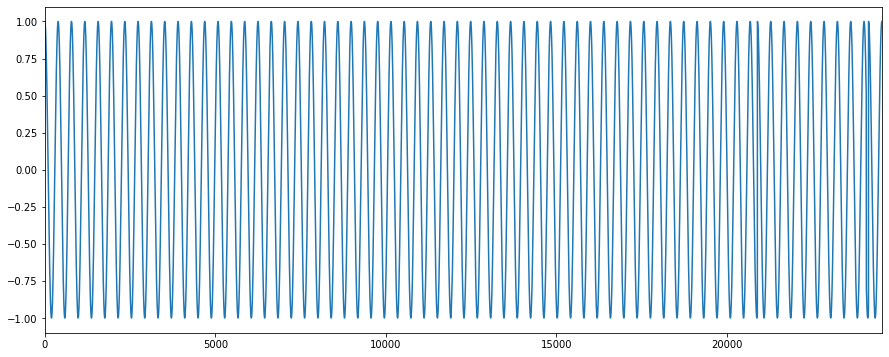

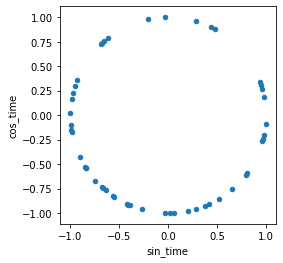

In [90]:
# Encoding cyclical continuous features for the trading day (6.5h a day except for shortened sessions)
start_market = 34200.0
df['seconds'] = (pd.to_datetime(df.datetime) - pd.to_datetime(df.datetime.str[:10])).dt.total_seconds() - start_market
seconds_trading_day = 57600.0-start_market  # specific to US EFTs, and not considering shortened trading sessions (2 per year).
df['sin_time'] = np.sin(2*np.pi*df.seconds/seconds_trading_day)
df['cos_time'] = np.cos(2*np.pi*df.seconds/seconds_trading_day)
df.cos_time.plot(figsize=(15,6))
df.sample(50).plot.scatter('sin_time','cos_time').set_aspect('equal');

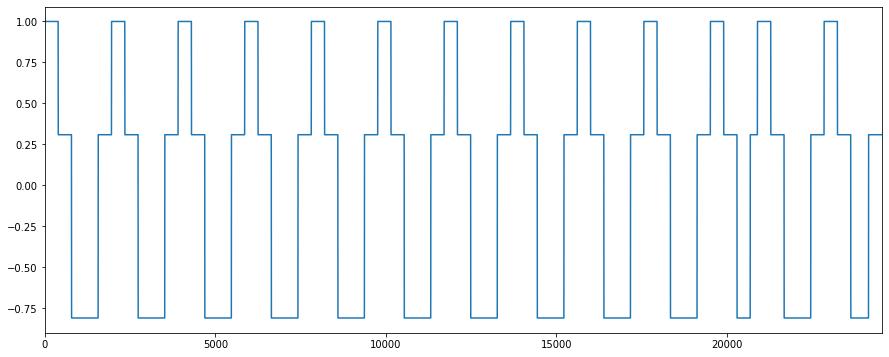

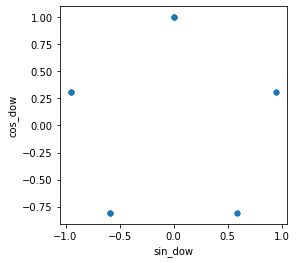

In [102]:
# Day of the week (cyclical also, for weeks of 5 days)
df['dow'] = pd.to_datetime(df.datetime).dt.dayofweek
df['sin_dow'] = np.sin(2*np.pi*df.dow/5)
df['cos_dow'] = np.cos(2*np.pi*df.dow/5)
df.cos_dow.plot(figsize=(15,6))
df.sample(50).plot.scatter('sin_dow','cos_dow').set_aspect('equal');

In [99]:
df.tail()

,datetime,open,high,low,close,volume,dow
24544,2017-12-08 15:56:00,265.275,265.350,265.275,265.33,352172.0,4
24545,2017-12-08 15:57:00,265.320,265.330,265.280,265.29,219547.0,4
24546,2017-12-08 15:58:00,265.290,265.295,265.250,265.26,75996.0,4
24547,2017-12-08 15:59:00,265.260,265.320,265.230,265.30,265389.0,4
24548,2017-12-08 16:00:00,265.300,265.510,265.300,265.51,2789347.0,4


In [74]:
# Select columns for output
# columns_selected=['rsi_10' ,'mom_10','ema_10','ema_20','ema_30',
#                  'sma_10','sma_20','sma_30','wma_10','wma_20','wma_30',
#                  'trima_10','trima_20','trima_30',
#                  'roc_10','rocr_10','ppo_10',
#                  'close','close_t-1','close_t-2','close_t-3','close_t-4',
#                  'label']
# df['label'] = df['binary_label']
# columns_selected=[# 'datetime',
#                  'rsi_10','willr_10','macd_macd' ,'cci_10','mom_10',
#                  'stoch_slowk','stoch_slowd',
#                  'sma_5','sma_10','sma_20','sma_30',
#                  'wma_5','wma_10','wma_20','wma_30',
#                  'ema_5','ema_10','ema_20','ema_30',
#                  'trima_5','trima_10','trima_20','trima_30',
#                  'adx_10','bbands_upperband','bbands_middleband','bbands_lowerband',
#                  'roc_10','rocr_10','stochf_fastd','stochf_fastk',
#                  'aroon_aroondown','aroon_aroonup','medprice_10','typprice_10','wclprice_10',
#                  'atr_10','macdfix_macd','sar_10',
#                  # 'volume','volume_t-1','volume_t-2','volume_t-3','volume_t-4',
#                  # 'close','close_t-1','close_t-2','close_t-3','close_t-4',
#                  # 'high','high_t-1','high_t-2','high_t-3','high_t-4',
#                  # 'open','open_t-1','open_t-2','open_t-3','open_t-4',
#                  # 'low','low_t-1','low_t-2','low_t-3','low_t-4',
#                  # 'binary_label',
#                  'label'] #,'gap_t+1','close_t+1'] # + ['adosc_10', 'obv_10', 'mfi_10', 'ppo_10']
#    
# best pool found through indicators grid search script
columns_selected = ['rsi_10','willr_10','macd_macd','cci_10','mom_10','stoch_slowk','stoch_slowd','sma_5','sma_10',
                    'wma_10','ema_10','trima_10','adx_10','bbands_upperband','bbands_lowerband','roc_10',
                    'aroon_aroondown','aroon_aroonup','label']

# Export processed data
output = pd.DataFrame(df, columns=columns_selected)
output.to_csv(RESULT_FILEPATH_PROCESSED, sep=',', encoding='utf-8', index = False)
create_arff_file(RESULT_FILEPATH_PROCESSED) # export in ARFF

# Printing classes distributions
print("Class distribution: ")
label_zero=len(df[df['label'] == 0])
label_one=len(df[df['label'] == 1])
#print(label_zero)
#print(label_one)
print("0 in "+str(float(label_zero)/(label_one+label_zero))+"%")
print("1 in "+str(float(label_one)/(label_one+label_zero))+"%")

%notify -m "Parsing is finished"

If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\PycharmProjects\RegimeSwitchingSeriesGenerator\output\spy_alphavantage_2019_2020_no_missing_data_market_hours_no_missing_data_30min-level_indicators_11062020.csv > C:\Users\suare\PycharmProjects\RegimeSwitchingSeriesGenerator\output\spy_alphavantage_2019_2020_no_missing_data_market_hours_no_missing_data_30min-level_indicators_11062020.arff
Class distribution: 
0 in 0.4735785953177257%
1 in 0.5264214046822743%


<IPython.core.display.Javascript object>

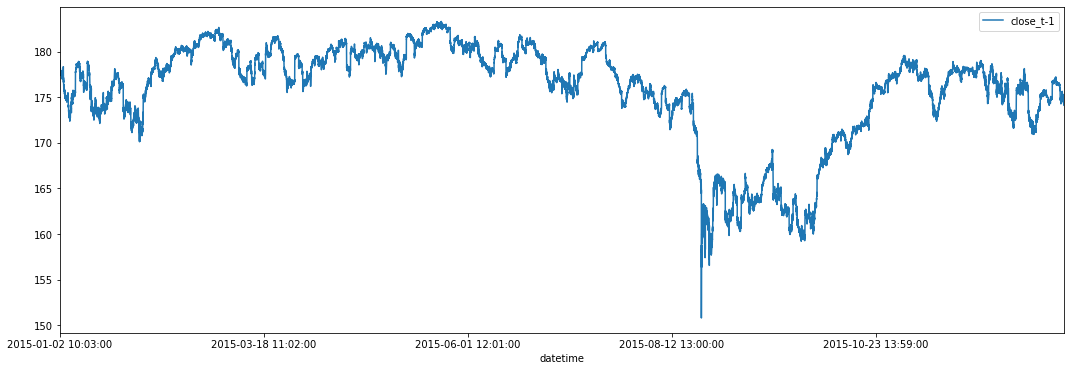

In [33]:
# Now plot close price and volume overtime.
import matplotlib.pyplot as plt
import pandas as pd

df.set_index('datetime',drop=True).plot(y=["close_t-1"], figsize=(18,6))
plt.show()

In [34]:
df.columns

Index(['datetime', 'open', 'high', 'low', 'close', 'volume', 'gap',
       'timestamp', 'close_t-1', 'close_t-2', 'close_t-3', 'close_t-4',
       'open_t-1', 'open_t-2', 'open_t-3', 'open_t-4', 'high_t-1', 'high_t-2',
       'high_t-3', 'high_t-4', 'low_t-1', 'low_t-2', 'low_t-3', 'low_t-4',
       'sma_5', 'sma_10', 'sma_20', 'sma_30', 'ema_5', 'ema_10', 'ema_20',
       'ema_30', 'wma_10', 'mom_10', 'stoch_slowk', 'stoch_slowd', 'macd_macd',
       'macd_macdsignal', 'macd_macdhist', 'rsi_10', 'willr_10', 'cci_10',
       'adx_10', 'aroon_aroondown', 'aroon_aroonup', 'bbands_upperband',
       'bbands_middleband', 'bbands_lowerband', 'trima_5', 'trima_10',
       'trima_20', 'trima_30', 'roc_10', 'rocr_10', 'stochf_fastk',
       'stochf_fastd', 'medprice_10', 'typprice_10', 'wclprice_10', 'atr_10',
       'macdfix_macd', 'macdfix_macdsignal', 'macdfix_macdhist', 'sar_10',
       'ppo_10', 'close_t+1', 'label'],
      dtype='object')

In [46]:
# # Creating a dictionary of technical indicators using TALib abstract API
# indicator = {}
# # Add as many indicators as necessary: see all indicators in https://mrjbq7.github.io/ta-lib/
# indicator['sma']=abstract.Function('sma') # Simple Moving Average
# indicator['ema']=abstract.Function('ema') # Exponential Moving Average
# indicator['mom']=abstract.Function('mom') # Momentum
# indicator['stoch']=abstract.Function('stoch') # Stochastic (returns K and D)
# indicator['macd']=abstract.Function('macd') # Moving Average Convergence/Divergence
# indicator['rsi']=abstract.Function('rsi') # Relative Strength Index
# indicator['willr']=abstract.Function('willr') # Williams' %R
# indicator['adosc']=abstract.Function('adosc') # Chaikin A/D Oscillator
# indicator['cci']=abstract.Function('cci') # Commodity Channel Index

# # --- --- 

# # extra columns
# indicator['adx']=abstract.Function('adx') # Average Directional Movement Index
# indicator['aroon']=abstract.Function('aroon') # Aroon
# indicator['bbands']=abstract.Function('bbands') # Bollinger Bands
# indicator['obv']=abstract.Function('obv') # On Balance Volume
# # 
# indicator['trima']=abstract.Function('trima') # Triangular Moving Average
# indicator['roc']=abstract.Function('roc') # Rate of change : ((price/prevPrice)-1)*100
# indicator['rocr']=abstract.Function('rocr') # Rate of change ratio: (price/prevPrice)
# indicator['stochf']=abstract.Function('stochf') # Stochastic fast (returns K and D)
# indicator['adosc']=abstract.Function('adosc') # Chaikin A/D Oscillator
# indicator['medprice']=abstract.Function('medprice') # Median Price
# indicator['typprice']=abstract.Function('typprice') # Typical Price
# indicator['wclprice']=abstract.Function('wclprice') # Weighted Close Price
# indicator['atr']=abstract.Function('atr') # Average True Range
# indicator['macdfix']=abstract.Function('macdfix') # #Moving Average Convergence/Divergence Fix 12/26
# indicator['mfi']=abstract.Function('mfi') # Money Flow Index

In [106]:
# BATCH

# Paths for symbols
DATA_PATH=os.sep.join(['C:','Users','suare','PycharmProjects','RegimeSwitchingSeriesGenerator','data'])
SOURCE_PATH=DATA_PATH 
RESULT_PATH=os.sep.join(['C:','Users','suare','PycharmProjects','RegimeSwitchingSeriesGenerator','output']) 

for file in files:
    filename = file.replace(SOURCE_PATH+os.sep,'')
    FIELD = 'close' # price->'ts' returns->'ret_ts' ts_with_added_noise-> 'ts_n2_post'
    print(f'Start {filename}')
    level = filename.split(os.sep)[1]
    print(level)

    file = os.sep.join([SOURCE_PATH, filename])
    RESULT_FILEPATH_PROCESSED = os.sep.join([RESULT_PATH, filename.split(os.sep)[-1].replace('.csv','')+'_'+level+'_indicators_20062020.csv'])
    
    # Open file
    df=pd.read_csv(file, sep=';')
    
#     print(df.head())
#     assert False
    df=df.drop_duplicates(['datetime','open','high','low','close','volume']) 
    
    #Add parameters to transform in TS
    timeseries=['close', 'open', 'high', 'low']
    #Length of the TS. How many values do we keep per serie. 
    # e.g. 1 -> t / 2 -> t,t-1 / 3 -> t,t-1,t-2 / 4 -> t,t-1,t-2,t-3
    length = 5
    # Add lagged times
    for column in timeseries:
        for i in range(1,length):
            df[column+'_t-'+str(i)]=df[column].shift(i) #it could also be sorted and group by if needed

#     default_series = 'open' # 'open' # 'close'  
#     if default_series == 'open':
#         df.close = df.open
# #         df.drop(columns=['open', 'high', 'low'], inplace=True)  # for test excluding high, low and close price (only open)
#         df.drop(columns=['open'], inplace=True)  # for test excluding high, low and close price (only open)
#         df.high = df.high.shift(1)
#         df.low = df.low.shift(1)
#         print('Dataframe size before and after dropping NaNs')
#         print(len(df))
#         df.dropna(inplace=True)
#         print(len(df))

    # all the numbers here and below assume a default time period for ta params of 10 mins averages
    # change the other numbers (params of 5min and 20min and theremoval of 20 first mins of the day below) if the mins number is changed.
    # in that case change as well the time tag '_10' with the corresponding one.
    default_timerange=10
    # Set extra timeranges for moving averages
    extra_timeranges=[default_timerange//2, default_timerange, default_timerange*2, default_timerange*3]

    # ###########################################
    # Iterate and run list of indicators selected
    # All of them produced for 25 prior mins of data 
    # ###########################################    
    for ind in list(indicators):
        print(ind)
        if ind not in ['adosc', 'obv', 'mfi']:  # for test excluding high, low and close price (only open)
#                        'stoch', 'willr', 'cci', 'adx', 'aroon', 'stochf', 'medprice', 'typprice', 'wclprice', 'atr', 
#                        'sar', 'ppo']:  # avoiding indicators that need volume
            # For indicators that only return one column (this will need to be modified depending on the selection of indicators)
            if ind in ['ema','sma','trima']:
                for timerange in extra_timeranges:
#                     print(ind+'_'+str(int(timerange)))
                    df[ind+'_'+str(int(timerange))] = get_indicator(ind)(df, timeperiod=timerange) 
            elif ind not in ['bbands','aroon','stoch','macd','macdfix','stochf']:
                df[ind+'_'+str(int(default_timerange))] = get_indicator(ind)(df, timeperiod=(default_timerange))
            # Otherwise check the list of columns and return all
            else: 
                key_output=get_indicator(ind)(df, timeperiod=(default_timerange)) #, price='close')
                for j in range(0,len(list(key_output.columns))):
                    df[ind+'_'+key_output.columns[int(j)]] = key_output[key_output.columns[j]]
#     for key in list(indicator.keys()):
#         # For indicators that only return one column (this will need to be modified depending on the selection of indicators)
#         if key in ['ema','sma','trima']:
#             df[key+'_'+str(default_timerange//2)]=indicator[key](df, timeperiod=(default_timerange/2)) 
#             df[key+'_'+str(default_timerange)]=indicator[key](df, timeperiod=(default_timerange)) 
#             df[key+'_'+str(default_timerange*2)]=indicator[key](df, timeperiod=(default_timerange*2))     
#         elif key not in ['bbands','aroon','stoch','macd','macdfix','stochf']:
#             df[key+'_'+str(default_timerange)]=indicator[key](df, timeperiod=(default_timerange))
#         # Otherwise check the list of columns and return all
#         else: 
#             key_output=indicator[key](df, timeperiod=(default_timerange)) #, price='close')
#             for j in range(0,len(list(key_output.columns))):
#                 df[key+'_'+key_output.columns[j]] = key_output[key_output.columns[j]]

    def set_label(row):
        if row['close_t+1'] > row['close']: return 1
        else: return 0

    # One minute ahead closing price
    df['close_t+1']=df['close'].shift(-1)
#     df['close_t+1']=df['close'].shift(-1)

#     def func(row):
#         if row['close_t+1'] > row['close']:
#             return 1
#         else:
#             return 0

    # Creating label/y to be predicted / independent (predicted) feature 'y' 
    df['label'] = df.apply(set_label, axis=1)
#     df['label'] = df.apply(func, axis=1)

    df.dropna(inplace=True)
    
    # Encoding cyclical continuous features for the trading day (6.5h a day except for shortened sessions)
    start_market = 34200.0 # 9:30am
    end_market = 57600.0 # 04:00pm
    df['seconds'] = (pd.to_datetime(df.datetime) - pd.to_datetime(df.datetime.str[:10])).dt.total_seconds() - start_market
    seconds_trading_day = end_market - start_market  # specific to US EFTs, and not considering shortened trading sessions (2 per year).
    df['sin_time'] = np.sin(2*np.pi*df.seconds/seconds_trading_day)
    df['cos_time'] = np.cos(2*np.pi*df.seconds/seconds_trading_day)
#     df.cos_time.plot(figsize=(15,6))
#     df.sample(50).plot.scatter('sin_time','cos_time').set_aspect('equal');
    
    # Day of the week (cyclical also, for weeks of 5 days)
    df['dow'] = pd.to_datetime(df.datetime).dt.dayofweek
    df['sin_dow'] = np.sin(2*np.pi*df.dow/5)
    df['cos_dow'] = np.cos(2*np.pi*df.dow/5)
#     df.cos_dow.plot(figsize=(15,6))
#     df.sample(50).plot.scatter('sin_dow','cos_dow').set_aspect('equal');

    # Select columns for output
    # best pool found through indicators grid search script
    columns_selected = ['rsi_10','willr_10','macd_macd','cci_10','mom_10','stoch_slowk','stoch_slowd','sma_5','sma_10',
                        'wma_10','ema_10','trima_10','adx_10','bbands_upperband','bbands_lowerband','roc_10',
                        'aroon_aroondown','aroon_aroonup', 'cos_time', 'cos_dow', 'label']
#     columns_selected = ['datetime', 'sma_5','ema_5','sma_20','ema_20','adosc_10','macd_macd','willr_10','stoch_slowk','stoch_slowd','cci_10','ema_10','rsi_10','sma_10','mom_10', 'label']

    # Export processed data
    print(df.head())
    output = pd.DataFrame(df, columns=columns_selected)[df['datetime'] >= '2017-09-25 14:07:00']
    output.to_csv(RESULT_FILEPATH_PROCESSED, sep=',', encoding='utf-8', index = False)
    devsets_path = 'C:\\Users\\suare\\Workspace\\phd_cetrulin\\moa-2017.06-sources\\data\\real\\real_financial_data_not_handling_gaps\\dev_sets\\'
#     create_arff_file(RESULT_FILEPATH_PROCESSED) # export in ARFF
    create_arff_file(RESULT_FILEPATH_PROCESSED, output=devsets_path+RESULT_FILEPATH_PROCESSED.split(os.sep)[-1]) # export in ARFF

    # Now plot close price and volume overtime.
    df.set_index('datetime',drop=True).plot(y=["close_t-1"], figsize=(18,6))
    plt.show()    
    
    df = output
    print(f'Number of instances: {len(df)}')
    # Printing classes distributions
    print("Class distribution: ")
    label_zero=len(df[df['label'] == 0])
    label_one=len(df[df['label'] == 1])
    #print(label_zero)
    #print(label_one)
    print("0 in "+str(float(label_zero)/(label_one+label_zero))+"%")
    print("1 in "+str(float(label_one)/(label_one+label_zero))+"%")

    %notify -m "Parsing is finished"    
    


Start efts\1min-level\S&P500\spy_alphavantage_2017_no_missing_data_market_hours_no_missing_data.csv
1min-level


AssertionError: 

In [13]:
# for test Test excluding close, high and low prices
# output.drop(columns=['willr_10', 'stoch_slowk', 'stoch_slowd', 'adx_10', 'aroon_aroondown', 'aroon_aroonup']).to_csv(RESULT_FILEPATH_PROCESSED, sep=',', encoding='utf-8', index = False)
# devsets_path = 'C:\\Users\\suare\\Workspace\\phd_cetrulin\\moa-2017.06-sources\\data\\real\\real_financial_data_not_handling_gaps\\dev_sets\\'
# #     create_arff_file(RESULT_FILEPATH_PROCESSED) # export in ARFF
# create_arff_file(RESULT_FILEPATH_PROCESSED, output=devsets_path+RESULT_FILEPATH_PROCESSED.split(os.sep)[-1]) # export in ARFF

# # Now plot close price and volume overtime.
# df.set_index('datetime',drop=True).plot(y=["close_t-1"], figsize=(18,6))
# plt.show()    

# df = output
# print(f'Number of instances: {len(df)}')
# # Printing classes distributions
# print("Class distribution: ")
# label_zero=len(df[df['label'] == 0])
# label_one=len(df[df['label'] == 1])
# #print(label_zero)
# #print(label_one)
# print("0 in "+str(float(label_zero)/(label_one+label_zero))+"%")
# print("1 in "+str(float(label_one)/(label_one+label_zero))+"%")

# %notify -m "Parsing is finished"    


In [165]:
# Number of instances: 20363
# Class distribution: 
# 0 in 0.5508520355546825%
# 1 in 0.44914796444531746%

## investigation of differences vs Google Finance (SPY20000)

In [24]:
import pandas as pd

# ALpha Vantage
av_path = 'C:\\Users\\suare\\OneDrive\\Escritorio\\spy_alphavantage_2017.csv'
av_df = pd.read_csv(av_path)
av_df.set_index('date', drop=True, inplace=True)
av_df.index = pd.to_datetime(av_df.index)
# av_df = av_df.resample('1min').mean().between_time('09:30', '16:00')
av_df = av_df[av_df.index.dayofweek < 5]  # no bank holidaysnin this period

# Google Finance
googfin_path = 'C:\\Users\\suare\\OneDrive\\Escritorio\\SPY_[2017-09-22_to_2017-12-09].csv'
googfin_df = pd.read_csv(googfin_path, sep=';')
googfin_df.drop(columns=['Unnamed: 0'], inplace=True)
googfin_df.set_index('date', drop=True, inplace=True)
googfin_df = googfin_df[googfin_df.index >= '2017-09-11 13:30:00']  # first date in av_df
googfin_df.index = pd.to_datetime(googfin_df.index) - pd.Timedelta(hours=4)
# googfin_df = googfin_df.resample('1min').mean().between_time('09:30', '16:00')
googfin_df = googfin_df[googfin_df.index.dayofweek < 5]

# There are exactly 251 trading days in 2017. February and April have the fewest (19), and March and August the most (23),
# with an average of 20.9 per month, or 62.8 per quarter.
# Out of a possible 365 days, 105 days are weekend days (Saturday and Sunday) when the stock exchanges are closed. 
# Eight of the nine holidays which close the exchanges fall on weekdays, 
#  with New Year's Day being observed on Monday, January 2. 
#     There are two shortened trading sessions: on Monday, July 3 (the day before Independence Day), 
#         and on Friday, November 24 (the day after Thanksgiving Day)

In [25]:
len(googfin_df)

24553

In [26]:
len(av_df)
# TODO

24550

In [20]:
googfin_df.index = pd.to_datetime(googfin_df.index)

In [21]:
googfin_df = googfin_df.resample('1min').mean().between_time('09:30', '16:00')

In [22]:
googfin_df = googfin_df[googfin_df.index.dayofweek < 5]  # no bank holidaysnin this period

In [29]:
googfin_df.head()

,open,high,low,close,volume
date,,,,,
2017-09-11 09:30:00,248.04,248.05,248.035,248.04,195320.0
2017-09-11 09:31:00,248.10,248.17,248.030,248.04,191201.0
2017-09-11 09:32:00,248.16,248.18,248.090,248.11,76710.0
2017-09-11 09:33:00,248.22,248.24,248.150,248.16,151905.0
2017-09-11 09:34:00,248.31,248.35,248.230,248.24,168466.0


In [30]:
av_df.head()

,close,high,low,open,volume
date,,,,,
2017-09-11 09:30:00,248.04,248.05,248.035,248.04,195320.0
2017-09-11 09:31:00,248.10,248.17,248.030,248.04,191201.0
2017-09-11 09:32:00,248.16,248.18,248.090,248.11,76710.0
2017-09-11 09:33:00,248.22,248.24,248.150,248.16,151905.0
2017-09-11 09:34:00,248.31,248.35,248.230,248.24,168466.0


In [111]:
googfin_df.head().merge(av_df.head())

,open,high,low,close,volume
0,248.04,248.05,248.035,248.04,195320.0


In [112]:
# Created DF to compare AV and Google Finance
merged_df = pd.merge(googfin_df, av_df, left_index=True, right_index=True, suffixes=('_goog', '_av'))

In [113]:
merged_df.head()

,open_goog,high_goog,low_goog,close_goog,volume_goog,close_av,high_av,low_av,open_av,volume_av
date,,,,,,,,,,
2017-09-11 09:30:00,248.04,248.05,248.035,248.04,195320.0,248.04,248.05,248.035,248.04,195320.0
2017-09-11 09:31:00,248.10,248.17,248.030,248.04,191201.0,248.10,248.17,248.030,248.04,191201.0
2017-09-11 09:32:00,248.16,248.18,248.090,248.11,76710.0,248.16,248.18,248.090,248.11,76710.0
2017-09-11 09:33:00,248.22,248.24,248.150,248.16,151905.0,248.22,248.24,248.150,248.16,151905.0
2017-09-11 09:34:00,248.31,248.35,248.230,248.24,168466.0,248.31,248.35,248.230,248.24,168466.0


In [114]:
merged_df['close_same_open'] = merged_df.close_goog - merged_df.open_av
merged_df['high_right'] = merged_df.high_goog - merged_df.high_av
merged_df['low_right'] = merged_df.low_goog - merged_df.low_av
merged_df['open_right'] = merged_df.open_goog - merged_df.open_av
merged_df['close_right'] = merged_df.close_goog - merged_df.close_av
merged_df['volume_right'] = merged_df.volume_goog - merged_df.volume_av

In [115]:
merged_df.tail()

,open_goog,high_goog,low_goog,close_goog,volume_goog,close_av,high_av,low_av,open_av,volume_av,close_same_open,high_right,low_right,open_right,close_right,volume_right
date,,,,,,,,,,,,,,,,
2017-12-08 15:56:00,265.12,265.170,265.12,265.170,6256.0,265.33,265.350,265.275,265.275,352172.0,-0.105,-0.180,-0.155,-0.155,-0.160,-345916.0
2017-12-08 15:57:00,265.09,265.115,265.09,265.110,3065.0,265.29,265.330,265.280,265.320,219547.0,-0.210,-0.215,-0.190,-0.230,-0.180,-216482.0
2017-12-08 15:58:00,265.08,265.090,265.08,265.090,7300.0,265.26,265.295,265.250,265.290,75996.0,-0.200,-0.205,-0.170,-0.210,-0.170,-68696.0
2017-12-08 15:59:00,265.06,265.085,265.06,265.085,18649.0,265.30,265.320,265.230,265.260,265389.0,-0.175,-0.235,-0.170,-0.200,-0.215,-246740.0
2017-12-08 16:00:00,265.12,265.120,265.05,265.065,25138.0,265.51,265.510,265.300,265.300,2789347.0,-0.235,-0.390,-0.250,-0.180,-0.445,-2764209.0


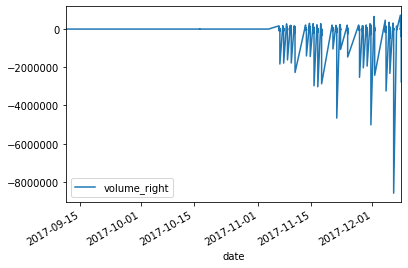

In [116]:
merged_df[['volume_right']].plot()  # there is clearly an issue with volumes since november

In [127]:
# filter timestamps with different volumes to compare the ones that should match
merged_df = merged_df[merged_df.volume_right == 0]
merged_df[merged_df['close_same_open'] == 0].tail()  # show last valid date

,open_goog,high_goog,low_goog,close_goog,volume_goog,close_av,high_av,low_av,open_av,volume_av,close_same_open,high_right,low_right,open_right,close_right,volume_right
date,,,,,,,,,,,,,,,,
2017-11-03 15:56:00,258.31,258.360,258.305,258.340,116028.0,258.31,258.360,258.305,258.340,116028.0,0.0,0.0,0.0,-0.030,0.030,0.0
2017-11-03 15:57:00,258.34,258.355,258.300,258.310,134620.0,258.34,258.355,258.300,258.310,134620.0,0.0,0.0,0.0,0.030,-0.030,0.0
2017-11-03 15:58:00,258.27,258.340,258.260,258.330,163910.0,258.27,258.340,258.260,258.330,163910.0,0.0,0.0,0.0,-0.060,0.060,0.0
2017-11-03 15:59:00,258.34,258.360,258.230,258.260,187378.0,258.34,258.360,258.230,258.260,187378.0,0.0,0.0,0.0,0.080,-0.080,0.0
2017-11-03 16:00:00,258.45,258.450,258.310,258.335,3002287.0,258.45,258.450,258.310,258.335,3002287.0,0.0,0.0,0.0,0.115,-0.115,0.0


In [126]:
merged_df.tail()

,open_goog,high_goog,low_goog,close_goog,volume_goog,close_av,high_av,low_av,open_av,volume_av,close_same_open,high_right,low_right,open_right,close_right,volume_right
date,,,,,,,,,,,,,,,,
2017-11-03 15:56:00,258.31,258.360,258.305,258.340,116028.0,258.31,258.360,258.305,258.340,116028.0,0.0,0.0,0.0,-0.030,0.030,0.0
2017-11-03 15:57:00,258.34,258.355,258.300,258.310,134620.0,258.34,258.355,258.300,258.310,134620.0,0.0,0.0,0.0,0.030,-0.030,0.0
2017-11-03 15:58:00,258.27,258.340,258.260,258.330,163910.0,258.27,258.340,258.260,258.330,163910.0,0.0,0.0,0.0,-0.060,0.060,0.0
2017-11-03 15:59:00,258.34,258.360,258.230,258.260,187378.0,258.34,258.360,258.230,258.260,187378.0,0.0,0.0,0.0,0.080,-0.080,0.0
2017-11-03 16:00:00,258.45,258.450,258.310,258.335,3002287.0,258.45,258.450,258.310,258.335,3002287.0,0.0,0.0,0.0,0.115,-0.115,0.0


Difference between google close and alpha vantage (same as quantquote) open prices
Difference of close prices


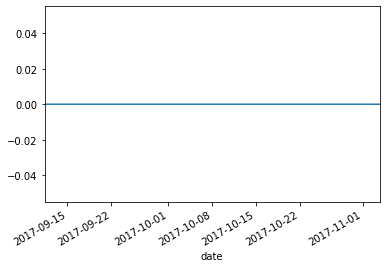

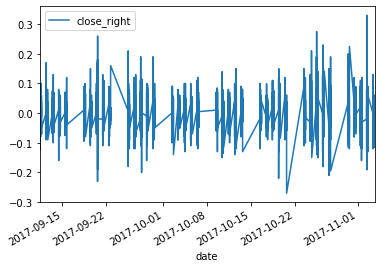

In [124]:
print('Difference between google close and alpha vantage (same as quantquote) open prices')
merged_df.close_same_open.plot() # there is a clear swap of open and close
print('Difference of close prices')
merged_df[['close_right']].plot()  # there is a clear swap of open and close

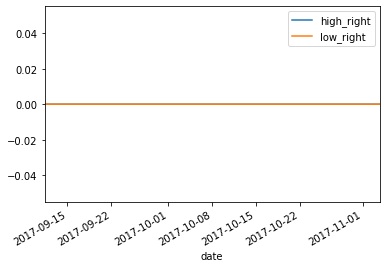

In [125]:
merged_df[['high_right', 'low_right']].plot() # high and low look right